<a href="https://colab.research.google.com/github/Halflernation/data-science-project1/blob/master/data_science_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project 1

Business Questions

	1. Are developers able to achieve salary progression through years of service?
	    - what is the correlation to their demographics?
	2. Which developers should employers target for the best value-for-money, and where?
	3. How well can we predict experience based on Salary/Expected Salary and programming skills? 

# Explore the dataset
First, we load the required libraries and explore a bit the dataset, looking for: how many answers we have, data-points (columns) and so on.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
# import AllTogether as t
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
df

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,SQLite,MySQL,MacOS;Windows,Android;Arduino;Windows,Django;Flask,Flask;jQuery,Node.js,Node.js,IntelliJ;Notepad++;PyCharm,Windows,I do not use containers,NaN,NaN,Yes,"Fortunately, someone else has that title",Yes,Twitter,Online,Username,2017,A few times per month or weekly,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,31-60 minutes,No,NaN,"No, I didn't know that Stack Overflow had a jo...","No, and I don't know what those are",Neutral,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,I am actively looking for a job,I've never had a job,NaN,NaN,Financial performance or funding status of the...,"Something else changed (education, award, medi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,MySQL,Windows,Windows,Django,Django,NaN,NaN,Atom;PyCharm,Windows,I do not use containers,NaN,Useful across many domains and could change ma...,Yes,Yes,Yes,Instagram,Online,Username,2017,Daily or almost daily,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,11-30 minutes,Yes,A few times per month or weekly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",3,22,1,Slightly satisfied,Slightly satisfied,Not at all confident,Not sure,Not sure,"I’m not actively looking, but I am open to new...",1-2 years ago,Interview with people in peer roles,No,"Languages, frameworks, and other technologies ...",I was preparing for a job search,THB,Thai baht,23000.0,Monthly,8820.0,40.0,There's no schedule or spec; I work on what se...,Distracting work environment;Inadequate access...,Less than once per month / Never

#### Unique `MainBranch` responses:

In [2]:
df.MainBranch.unique()

array(['I am a student who is learning to code',
       'I am not primarily a developer, but I write code sometimes as part of my work',
       'I am a developer by profession', 'I code primarily as a hobby',
       'I used to be a developer by profession, but no longer am', nan],
      dtype=object)

## 1. Are developers able to achieve salary progression through years of service?
* what is the correlation to their demographics?

In this section, we're interested in the professional developers exclusively. Those who have been but today are might also be of interest since we may be able to analyse their progression even if, we may not be able to correlate how desirable they are as programmers.

From the DataSet: we know we're starting with 88883 responses.

#### Dropping everyone that is not a i) Professional developer and ii) used to be a developer. We also clean the answers of those who did not respond to such questions of course.

In [3]:
df = df.dropna(axis=0, how="any", subset=['MainBranch']) # Dropping 2 non-respondents

# Dropping types of coders but the professional, current or past:
df = df[df.MainBranch != "I am a student who is learning to code"]
df = df[df.MainBranch != "I am not primarily a developer, but I write code sometimes as part of my work"]
df = df[df.MainBranch != "I code primarily as a hobby"]

# Dropping responses if they do not include salary or years of coding:
df = df.dropna(axis=0, how="any", subset=['ConvertedComp', 'YearsCode', 'YearsCodePro'])
df

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,100 to 499 employees,"Developer, full-stack",3,16,Less than 1 year,Very satisfied,Slightly satisfied,Very confident,No,Not sure,I am not interested in new job opportunities,Less than a year ago,"Write code by hand (e.g., on a whiteboard);Int...",No,"Languages, frameworks, and other technologies ...",I was preparing for a job search,USD,United States dollar,61000.0,Yearly,61000.0,80.00,There's no schedule or spec; I work on what se...,NaN,Less than once per month / Never,Home,A little below average,No,NaN,...,MySQL;SQLite,MySQL;SQLite,Linux;Windows,Linux;Windows,NaN,NaN,.NET,.NET,Eclipse;Vim;Visual Studio;Visual Studio Code,Windows,I do not use containers,Not at all,"Useful for decentralized currency (i.e., Bitcoin)",Yes,SIGH,Yes,Reddit,In real life (in person),Username,2014,Daily or almost daily,Find answers to specific questions;Pass the ti...,1-2 times per week,Stack Overflow was much faster,31-60 minutes,Yes,Less than once per month or monthly,Yes,"No, and I don't know what those are","No, not really",Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
8,9,I am a developer by profession,Yes,Once a month or more often,The quality of OSS and closed source software ...,Employed full-time,New Zealand,No,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,10 to 19 employees,"Database administrator;Developer, back-end;Dev...",12,11,4,Slightly satisfied,Slightly satisfied,Somewhat confident,No,Not sure,"I’m not actively looking, but I am open to new...",Less than a year ago,Write any code;Interview with people in peer r...,Yes,Financial performance or funding status of the...,I was preparing for a job search,NZD,New Zealand dollar,138000.0,Yearly,95179.0,32.00,There is a schedule and/or spec (made by me or...,Being tasked with non-development work;Inadequ...,Less than once per month / Never,Office,A little above average,"Yes, because I see value in code review",12.0,...,DynamoDB;PostgreSQL;SQLite,PostgreSQL;Redis;SQLite,AWS;Docker;Heroku;Linux;MacOS;Slack,AWS;Docker;Heroku;Linux;MacOS;Slack;Other(s):,Express;Ruby on Rails;Other(s):,Express;Ruby on Rails;Other(s):,Node.js;Unity 3D,Node.js,Vim,MacOS,Development;Testing;Production,Not at all,An irresponsible use of resources,No,SIGH,Yes,Twitter,In real life (in person),Username,2013,Daily or almost daily,Find answers to specific questions;Contribute ...,3-5 times per week,They were about the same,NaN,Yes,Less than once per month or monthly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,NaN,23

We have **50364** responses from all current or past professional developers.

#### Let's focus on the parameters we want to track:

In [4]:
df = df[['Age', 'Gender', 'Dependents', 'Country', 'ConvertedComp', 'YearsCode', 'Age1stCode', 'YearsCodePro', 'MainBranch', 'DevType', 'Employment', 'EdLevel', 'UndergradMajor', 'EduOther']]
df

,Age,Gender,Dependents,Country,ConvertedComp,YearsCode,Age1stCode,YearsCodePro,MainBranch,DevType,Employment,EdLevel,UndergradMajor,EduOther
3,22.0,Man,No,United States,61000.0,3,16,Less than 1 year,I am a developer by profession,"Developer, full-stack",Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
8,23.0,Man,No,New Zealand,95179.0,12,11,4,I am a developer by profession,"Database administrator;Developer, back-end;Dev...",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
9,NaN,NaN,Yes,India,13293.0,12,20,10,I am a developer by profession,Data or business analyst;Data scientist or mac...,Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",NaN,NaN
12,28.0,Man,Yes,United States,90000.0,17,11,8,I am a developer by profession,Data or business analyst;Database administrato...,Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
13,31.0,Man,No,Germany,57060.0,13,16,2,I am a developer by profession,"Developer, desktop or enterprise applications",Employed full-time,"Other doctoral degree (Ph.D, Ed.D., etc.)","Computer science, computer engineering, or sof...",Completed an industry certification program (e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88325,26.0,Man,No,United States,130000.0,12,14,3,I am a developer by profession,"Developer, back-end;Developer, front-end;Devel...",Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
88326,34.0,Man,No,Finland,82488.0,17,16,7,I am a developer by profession,"Developer, desktop or enterprise applications;...",Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...","Taught yourself a new language, framework, or ..."
88328,37.0,Man,No,Austria,68745.0,18,17,9,I am a developer by profession,"Developer, full-stack;Engineer, site reliability",Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
88329,NaN,Man,Yes,Netherlands,588012.0,10,15,8,I am a developer by profession,Academic researcher;Database administrator;Dev...,Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Participated in online coding competitions (e....


In [5]:
df.YearsCodePro.unique()

array(['Less than 1 year', '4', '10', '8', '2', '3', '13', '18', '1',
       '14', '22', '23', '19', '20', '9', '25', '7', '5', '27', '48',
       '12', '31', '11', '6', '17', '15', '16', '21', '26', '30', '33',
       '35', '37', '29', '28', '34', '24', '39', '40', '32', '45', '38',
       '44', '36', '43', '41', '42', '50', 'More than 50 years', '47',
       '46', '49'], dtype=object)

We further clean values for the responses for bottom and upper range.
So we transform 'Less than 1 year' into '1' and 'More than 50 years' into '50'

* Is this something we can do without skewing the data?
Let's find out.

In [6]:
(df.YearsCode == 'Less than 1 year').value_counts()
(df.YearsCode == 'Less than 1 year').value_counts() / df.YearsCode.count()
# So 130 responses are for 'Less than 1 year' and this is ~0.0026% of total.

(df.YearsCode == 'More than 50 years').value_counts()
(df.YearsCode == 'More than 50 years').value_counts() / df.YearsCode.count()
# So 16 responses are for 'More than 50 years' and this is ~0.0003% of total.

(df.YearsCodePro == 'Less than 1 year').value_counts()
(df.YearsCodePro == 'Less than 1 year').value_counts() / df.YearsCodePro.count()
# So 2179 responses are for 'Less than 1 year' and this is 0.04% of total.

(df.YearsCodePro == 'More than 50 years').value_counts()
(df.YearsCodePro == 'More than 50 years').value_counts() / df.YearsCodePro.count()
# So 10 responses are for 'More than 50 years' and this is ~0.0002% of total.

False    0.999801
True     0.000199
Name: YearsCodePro, dtype: float64

It is safe to say we can aggregate this values to 1 year and 50 years of coding respectively without impacting the relevancy of the data.

**Let's do it!**

In [7]:
df.YearsCode.replace('Less than 1 year', '1', inplace=True)
df.YearsCode.replace('More than 50 years', '50', inplace=True)

df.YearsCodePro.replace('Less than 1 year', '1', inplace=True)
df.YearsCodePro.replace('More than 50 years', '50', inplace=True)

# Convert columns to numeric values
df.YearsCode = pd.to_numeric(df.YearsCode)
df.YearsCodePro = pd.to_numeric(df.YearsCodePro)

# Let's check:
df.dtypes

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Age               float64
Gender             object
Dependents         object
Country            object
ConvertedComp     float64
YearsCode           int64
Age1stCode         object
YearsCodePro        int64
MainBranch         object
DevType            object
Employment         object
EdLevel            object
UndergradMajor     object
EduOther           object
dtype: object

Let's analyse the data we have now.

We want to answer if developers are able to achieve salary progression through years of service.
Let's plot the current distribution of answers first.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f737ee37f98>,
      dtype=object)

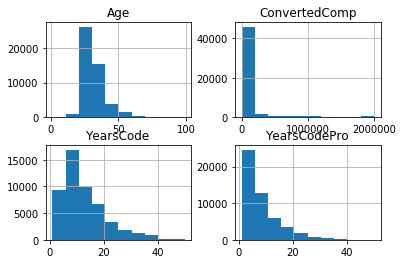

In [8]:
df.hist()

This didn't tell us much.
What we know:
* Salary variance seems low. We'll confirm this matematically.
* We have a good distribution of people coding throughout many years and an OK age group distribution.

In [9]:
# So let's see about salary distribution:
df.ConvertedComp.describe()
# count    5.036400e+04
# mean     1.268866e+05
# std      2.842949e+05
# min      0.000000e+00
# 25%      2.565600e+04
# 50%      5.728700e+04
# 75%      1.000000e+05
# max      2.000000e+06

df.ConvertedComp.median()
# 57287.0

57287.0

In [23]:
# Count individual replies (we need to clean a few things first, otherwise we get too much results!):
comp_40 = df[df.ConvertedComp < 40000].ConvertedComp.count()
comp_80 = df[df.ConvertedComp < 80000].ConvertedComp.count() - comp_40
comp_120 = df[df.ConvertedComp < 120000].ConvertedComp.count() - comp_80
comp_160 = df[df.ConvertedComp < 160000].ConvertedComp.count() - comp_120
comp_200 = df[df.ConvertedComp < 99999999].ConvertedComp.count() - comp_160

possible_values = ["Below $40k", "$40k - $80k", "$80k - $120k", "$120k - $160k", "$160k - max"];

study = df['ConvertedComp'].value_counts().reset_index()
study.rename(columns={'index': 'Compensation', 'ConvertedComp': 'count'}, inplace=True)

study


# (df.ConvertedComp.value_counts() / df.ConvertedComp.count()).plot(kind="bar", legend=None);
# plt.title("Compensation distribution");

,Compensation,count
0,2000000.0,645
1,1000000.0,492
2,120000.0,459
3,100000.0,433
4,150000.0,400
...,...,...
8648,343000.0,1
8649,42180.0,1
8650,64680.0,1
8651,19391.0,1
